# UNeXt 
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [2]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7ac1ce086657e1be65b0faa86853b1e67bbf3dc132c68324dbf891d57db50325
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=97c84409d36ec9fef048db8d4f9579efb4d5f0935db8a36f5c1990e35a051bc8
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientn

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
#from torchvision.transforms import v2
from torchvision import transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb



def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W

sigmoid = nn.Sigmoid()
if torch.cuda.is_available():
    sigmoid = sigmoid.cuda()
    
class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.input_channels = input_channels
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

#         self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        out = self.final(out)
        
        if not self.training:
            out = sigmoid(out)
            out = torch.where(out>0.5,torch.ones_like(out),torch.zeros_like(out))
        return out


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

#         self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        out = self.final(out)
        if not self.training:
            out = sigmoid(out)
            out = torch.where(out>0.5,torch.ones_like(out),torch.zeros_like(out))
        return out


#EOF


## DataSet

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([     transforms.Resize(size), 
                                             transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                             transforms.RandomVerticalFlip(),    # 随机垂直旋转
                                             transforms.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             transforms.ToTensor()
#                                              , v2.ConvertImageDtype()
                                            ])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path).copy()
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path).copy()

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
        
        mask_img = torch.where(mask_img>0.5,torch.ones_like(mask_img),torch.zeros_like(mask_img))
        return orig_img, mask_img


In [6]:
batch_size=6

dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=batch_size,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
showing image of 43: 


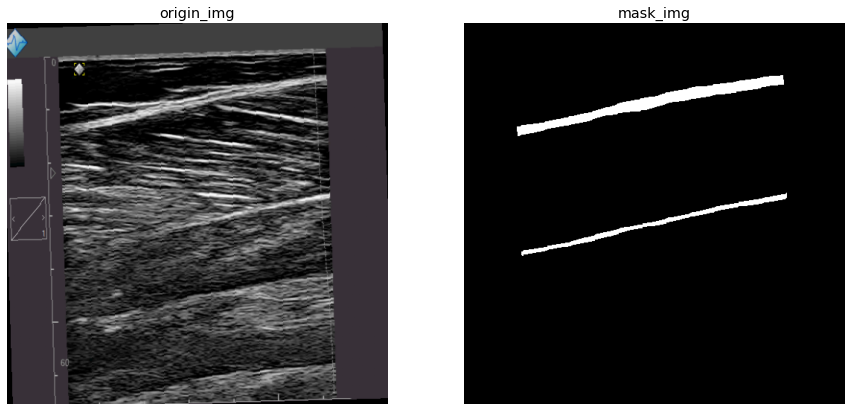

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]

print(orig_img.size())
print(mask_img.size())


print("showing image of {}: ".format(idx))

orig_img = orig_img.cpu().numpy().transpose(1, 2, 0)
mask_img = mask_img.cpu().numpy().transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.grid(False)
ax1.axis('off')
ax1.set_title("origin_img")

ax2.imshow(mask_img, cmap="gray")
ax2.grid(False)
ax2.axis('off')
ax2.set_title("mask_img")

plt.show()

## 模型训练

In [9]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login


# (Initialize logging)
experiment = wandb.init(project='U-NXet', resume='allow', anonymous='must', notes='水平和垂直翻转，旋转(-10,10)度')
experiment.config.update(
    dict(epochs=200, batch_size=batch_size, amp=True)
)

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [10]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.num_classes
    else:
        n_classes = net.num_classes
    criterion = nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    if torch.cuda.is_available():
        criterion = criterion.cuda()
        dice_loss = dice_loss.cuda()
        
    
    print("Validation round")
    # iterate over the validation set
#     with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
        images, mask_trues = batch

         # move images and labels to correct device and type
        images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        mask_trues = mask_trues.to(device=device, dtype=torch.float32)

        # predict the mask
        mask_preds = net(images)
        dice_score += criterion(mask_preds, mask_trues.float())
        dice_score += dice_loss(mask_preds, mask_trues)
            
        tp, fp, fn, tn = smp.metrics.get_stats(mask_preds, mask_trues.long(), mode='binary', threshold=0.5)
        iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    
    try:
        histograms = {}
        for tag, value in net.named_parameters():
            tag = tag.replace('/', '.')
            if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

        experiment.log({
            'validation Dice Loss': dice_loss,
            'validation IoU Score': iou_score,
            'images': wandb.Image(images[0].cpu()),
            'masks': {
                'true': wandb.Image(mask_trues[0].float().cpu()),
                'pred': wandb.Image(mask_preds[0].float().cpu()),
            },
            **histograms
        })
    except Exception as e:
        print(e)
#         pass
    
    return (dice_loss, iou_score)

In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 200,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 6,
          amp: bool = False,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.num_classes
        n_channels = model.module.input_channels
    else:
        n_classes = model.num_classes
        n_channels = model.input_channels

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice scor
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()

    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (2 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNext(n_channels=3, num_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device, batch_size=batch_size)

    

Let's use 2 GPUs!
模型参数量为：1471921
其详情为：
module.encoder1.weight : torch.Size([16, 3, 3, 3])
module.encoder1.bias : torch.Size([16])
module.encoder2.weight : torch.Size([32, 16, 3, 3])
module.encoder2.bias : torch.Size([32])
module.encoder3.weight : torch.Size([128, 32, 3, 3])
module.encoder3.bias : torch.Size([128])
module.ebn1.weight : torch.Size([16])
module.ebn1.bias : torch.Size([16])
module.ebn2.weight : torch.Size([32])
module.ebn2.bias : torch.Size([32])
module.ebn3.weight : torch.Size([128])
module.ebn3.bias : torch.Size([128])
module.norm3.weight : torch.Size([160])
module.norm3.bias : torch.Size([160])
module.norm4.weight : torch.Size([256])
module.norm4.bias : torch.Size([256])
module.dnorm3.weight : torch.Size([160])
module.dnorm3.bias : torch.Size([160])
module.dnorm4.weight : torch.Size([128])
module.dnorm4.bias : torch.Size([128])
module.block1.0.norm2.weight : torch.Size([160])
module.block1.0.norm2.bias : torch.Size([160])
module.block1.0.mlp.fc1.weight : torch.Size([160

Epoch 1/200:  50%|█████     | 228/456 [00:22<00:10, 21.83img/s, loss (batch)=1.44]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.59batch/s]


Validation dice loss: 1.6215726137161255, IoU Score 0.0


Epoch 1/200: 100%|██████████| 456/456 [00:37<00:00, 20.81img/s, loss (batch)=1.38]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.97batch/s]


Validation dice loss: 1.6225532293319702, IoU Score 0.001305913901887834


Epoch 2/200:  50%|█████     | 228/456 [00:10<00:10, 21.41img/s, loss (batch)=1.34]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.41batch/s]


Validation dice loss: 1.622092604637146, IoU Score 0.00367793720215559


Epoch 2/200: 100%|██████████| 456/456 [00:25<00:00, 22.39img/s, loss (batch)=1.31]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.72batch/s]


Validation dice loss: 1.621573567390442, IoU Score 0.009980075061321259


Epoch 3/200:  50%|█████     | 228/456 [00:10<00:10, 21.85img/s, loss (batch)=1.27]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.06batch/s]


Validation dice loss: 1.6173783540725708, IoU Score 0.07873143255710602


Epoch 3/200: 100%|██████████| 456/456 [00:25<00:00, 21.19img/s, loss (batch)=1.27]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.69batch/s]


Validation dice loss: 1.6095902919769287, IoU Score 0.2329360544681549


Epoch 4/200:  50%|█████     | 228/456 [00:10<00:10, 21.61img/s, loss (batch)=1.24]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.14batch/s]


Validation dice loss: 1.6052095890045166, IoU Score 0.34010761976242065


Epoch 4/200: 100%|██████████| 456/456 [00:24<00:00, 22.21img/s, loss (batch)=1.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.6016192436218262, IoU Score 0.4285944402217865


Epoch 5/200:  50%|█████     | 228/456 [00:10<00:10, 22.43img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.81batch/s]


Validation dice loss: 1.600592017173767, IoU Score 0.4541017711162567


Epoch 5/200: 100%|██████████| 456/456 [00:25<00:00, 22.36img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.02batch/s]


Validation dice loss: 1.5985889434814453, IoU Score 0.5048422813415527


Epoch 6/200:  50%|█████     | 228/456 [00:10<00:10, 21.90img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.20batch/s]


Validation dice loss: 1.598527431488037, IoU Score 0.5087735056877136


Epoch 6/200: 100%|██████████| 456/456 [00:25<00:00, 21.79img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.58batch/s]


Validation dice loss: 1.597872018814087, IoU Score 0.5257040858268738


Epoch 7/200:  50%|█████     | 228/456 [00:10<00:10, 21.74img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.30batch/s]


Validation dice loss: 1.5976667404174805, IoU Score 0.5317028760910034


Epoch 7/200: 100%|██████████| 456/456 [00:25<00:00, 21.84img/s, loss (batch)=0.99]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.55batch/s]


Validation dice loss: 1.5967212915420532, IoU Score 0.5430132746696472


Epoch 8/200:  50%|█████     | 228/456 [00:10<00:10, 22.27img/s, loss (batch)=0.975]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.52batch/s]


Validation dice loss: 1.596593976020813, IoU Score 0.5521625280380249


Epoch 8/200: 100%|██████████| 456/456 [00:25<00:00, 21.50img/s, loss (batch)=0.929]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.65batch/s]


Validation dice loss: 1.5962682962417603, IoU Score 0.5519154667854309


Epoch 9/200:  50%|█████     | 228/456 [00:10<00:10, 21.60img/s, loss (batch)=0.928]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.86batch/s]


Validation dice loss: 1.5956673622131348, IoU Score 0.563032865524292


Epoch 9/200: 100%|██████████| 456/456 [00:25<00:00, 21.80img/s, loss (batch)=0.862]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.10batch/s]


Validation dice loss: 1.5955393314361572, IoU Score 0.5648669600486755


Epoch 10/200:  50%|█████     | 228/456 [00:10<00:10, 22.17img/s, loss (batch)=0.819]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.88batch/s]


Validation dice loss: 1.5964995622634888, IoU Score 0.5532206296920776


Epoch 10/200: 100%|██████████| 456/456 [00:25<00:00, 21.65img/s, loss (batch)=0.833]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.74batch/s]


Validation dice loss: 1.5950031280517578, IoU Score 0.5725887417793274


Epoch 11/200:  50%|█████     | 228/456 [00:10<00:10, 21.69img/s, loss (batch)=0.777]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.91batch/s]


Validation dice loss: 1.5952796936035156, IoU Score 0.5649962425231934


Epoch 11/200: 100%|██████████| 456/456 [00:25<00:00, 21.60img/s, loss (batch)=0.841]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.72batch/s]


Validation dice loss: 1.5955512523651123, IoU Score 0.568500816822052


Epoch 12/200:  50%|█████     | 228/456 [00:10<00:10, 22.06img/s, loss (batch)=0.722]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.17batch/s]


Validation dice loss: 1.5951999425888062, IoU Score 0.5672301054000854


Epoch 12/200: 100%|██████████| 456/456 [00:25<00:00, 21.20img/s, loss (batch)=0.842]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.5950936079025269, IoU Score 0.5729434490203857


Epoch 13/200:  50%|█████     | 228/456 [00:10<00:10, 21.45img/s, loss (batch)=0.793]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.98batch/s]


Validation dice loss: 1.5958744287490845, IoU Score 0.5644291639328003


Epoch 13/200: 100%|██████████| 456/456 [00:25<00:00, 22.07img/s, loss (batch)=0.713]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.42batch/s]


Validation dice loss: 1.5941181182861328, IoU Score 0.5936057567596436


Epoch 14/200:  50%|█████     | 228/456 [00:10<00:10, 21.35img/s, loss (batch)=0.816]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.19batch/s]


Validation dice loss: 1.594619870185852, IoU Score 0.5838443636894226


Epoch 14/200: 100%|██████████| 456/456 [00:25<00:00, 21.77img/s, loss (batch)=0.694]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.51batch/s]


Validation dice loss: 1.5945298671722412, IoU Score 0.5844663977622986


Epoch 15/200:  50%|█████     | 228/456 [00:10<00:10, 21.34img/s, loss (batch)=0.599]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.60batch/s]


Validation dice loss: 1.5945335626602173, IoU Score 0.5889720320701599


Epoch 15/200: 100%|██████████| 456/456 [00:25<00:00, 22.14img/s, loss (batch)=0.665]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.08batch/s]


Validation dice loss: 1.5943078994750977, IoU Score 0.5882154107093811


Epoch 16/200:  50%|█████     | 228/456 [00:10<00:10, 22.10img/s, loss (batch)=0.596]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.12batch/s]


Validation dice loss: 1.5940186977386475, IoU Score 0.5989668369293213


Epoch 16/200: 100%|██████████| 456/456 [00:24<00:00, 22.12img/s, loss (batch)=0.567]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.89batch/s]


Validation dice loss: 1.5930860042572021, IoU Score 0.6150659918785095


Epoch 17/200:  50%|█████     | 228/456 [00:10<00:10, 21.44img/s, loss (batch)=0.697]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.55batch/s]


Validation dice loss: 1.5938332080841064, IoU Score 0.6041049957275391


Epoch 17/200: 100%|██████████| 456/456 [00:25<00:00, 21.95img/s, loss (batch)=0.558]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.69batch/s]


Validation dice loss: 1.593328833580017, IoU Score 0.6092619895935059


Epoch 18/200:  50%|█████     | 228/456 [00:10<00:10, 21.70img/s, loss (batch)=0.492]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.01batch/s]


Validation dice loss: 1.5927761793136597, IoU Score 0.6208696365356445


Epoch 18/200: 100%|██████████| 456/456 [00:24<00:00, 21.91img/s, loss (batch)=0.591]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.49batch/s]


Validation dice loss: 1.592941164970398, IoU Score 0.6234269142150879


Epoch 19/200:  50%|█████     | 228/456 [00:10<00:10, 22.57img/s, loss (batch)=0.559]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.52batch/s]


Validation dice loss: 1.5927153825759888, IoU Score 0.619947612285614


Epoch 19/200: 100%|██████████| 456/456 [00:24<00:00, 21.48img/s, loss (batch)=0.5]  

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.33batch/s]


Validation dice loss: 1.5932888984680176, IoU Score 0.6115050911903381


Epoch 20/200:  50%|█████     | 228/456 [00:10<00:10, 22.29img/s, loss (batch)=0.542]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 1.593263030052185, IoU Score 0.616016149520874


Epoch 20/200: 100%|██████████| 456/456 [00:25<00:00, 22.05img/s, loss (batch)=0.451]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.04batch/s]


Validation dice loss: 1.5922361612319946, IoU Score 0.6261470317840576


Epoch 21/200:  50%|█████     | 228/456 [00:10<00:10, 22.32img/s, loss (batch)=0.393]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.57batch/s]


Validation dice loss: 1.5921961069107056, IoU Score 0.6282157301902771


Epoch 21/200: 100%|██████████| 456/456 [00:25<00:00, 21.76img/s, loss (batch)=0.472]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.02batch/s]


Validation dice loss: 1.5928457975387573, IoU Score 0.6177343130111694


Epoch 22/200:  50%|█████     | 228/456 [00:10<00:10, 22.10img/s, loss (batch)=0.408]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.71batch/s]


Validation dice loss: 1.5916763544082642, IoU Score 0.6364210247993469


Epoch 22/200: 100%|██████████| 456/456 [00:25<00:00, 21.32img/s, loss (batch)=0.354]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.35batch/s]


Validation dice loss: 1.5922930240631104, IoU Score 0.6295843720436096


Epoch 23/200:  50%|█████     | 228/456 [00:10<00:10, 22.12img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.09batch/s]


Validation dice loss: 1.5921688079833984, IoU Score 0.6352313756942749


Epoch 23/200: 100%|██████████| 456/456 [00:24<00:00, 21.69img/s, loss (batch)=0.434]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.34batch/s]


Validation dice loss: 1.5919240713119507, IoU Score 0.6346193552017212


Epoch 24/200:  50%|█████     | 228/456 [00:10<00:10, 21.71img/s, loss (batch)=0.512]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.61batch/s]


Validation dice loss: 1.5920400619506836, IoU Score 0.6379191279411316


Epoch 24/200: 100%|██████████| 456/456 [00:25<00:00, 22.47img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.09batch/s]


Validation dice loss: 1.591758370399475, IoU Score 0.6381598114967346


Epoch 25/200:  50%|█████     | 228/456 [00:10<00:10, 20.85img/s, loss (batch)=0.43] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.26batch/s]


Validation dice loss: 1.5917744636535645, IoU Score 0.64155113697052


Epoch 25/200: 100%|██████████| 456/456 [00:25<00:00, 22.27img/s, loss (batch)=0.342]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.23batch/s]


Validation dice loss: 1.5931930541992188, IoU Score 0.61688232421875


Epoch 26/200:  50%|█████     | 228/456 [00:10<00:10, 21.66img/s, loss (batch)=0.505]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.00batch/s]


Validation dice loss: 1.5917378664016724, IoU Score 0.6432332992553711


Epoch 26/200: 100%|██████████| 456/456 [00:25<00:00, 21.84img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.49batch/s]


Validation dice loss: 1.5918012857437134, IoU Score 0.6409990191459656


Epoch 27/200:  50%|█████     | 228/456 [00:10<00:10, 22.31img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.08batch/s]


Validation dice loss: 1.591829538345337, IoU Score 0.6378482580184937


Epoch 27/200: 100%|██████████| 456/456 [00:25<00:00, 23.10img/s, loss (batch)=0.474]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.47batch/s]


Validation dice loss: 1.591740369796753, IoU Score 0.6446371078491211


Epoch 28/200:  50%|█████     | 228/456 [00:10<00:10, 22.35img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.53batch/s]


Validation dice loss: 1.5917390584945679, IoU Score 0.6374915242195129


Epoch 28/200: 100%|██████████| 456/456 [00:25<00:00, 22.39img/s, loss (batch)=0.336]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.39batch/s]


Validation dice loss: 1.5923385620117188, IoU Score 0.6356302499771118


Epoch 29/200:  50%|█████     | 228/456 [00:10<00:10, 21.19img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.79batch/s]


Validation dice loss: 1.5916407108306885, IoU Score 0.6505978107452393


Epoch 29/200: 100%|██████████| 456/456 [00:25<00:00, 21.85img/s, loss (batch)=0.511]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.5914949178695679, IoU Score 0.6546568870544434


Epoch 30/200:  50%|█████     | 228/456 [00:10<00:10, 21.73img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.23batch/s]


Validation dice loss: 1.5908845663070679, IoU Score 0.6571411490440369


Epoch 30/200: 100%|██████████| 456/456 [00:25<00:00, 22.87img/s, loss (batch)=0.568]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.21batch/s]


Validation dice loss: 1.5908327102661133, IoU Score 0.6559715270996094


Epoch 31/200:  50%|█████     | 228/456 [00:10<00:10, 21.86img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.66batch/s]


Validation dice loss: 1.5914732217788696, IoU Score 0.6525799632072449


Epoch 31/200: 100%|██████████| 456/456 [00:25<00:00, 22.23img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.73batch/s]


Validation dice loss: 1.5915313959121704, IoU Score 0.6528199911117554


Epoch 32/200:  50%|█████     | 228/456 [00:10<00:10, 21.27img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.69batch/s]


Validation dice loss: 1.5912463665008545, IoU Score 0.6535001397132874


Epoch 32/200: 100%|██████████| 456/456 [00:25<00:00, 22.99img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.24batch/s]


Validation dice loss: 1.5915321111679077, IoU Score 0.6466624140739441


Epoch 33/200:  50%|█████     | 228/456 [00:10<00:10, 21.83img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.55batch/s]


Validation dice loss: 1.5912120342254639, IoU Score 0.6536474823951721


Epoch 33/200: 100%|██████████| 456/456 [00:25<00:00, 21.59img/s, loss (batch)=0.424]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.05batch/s]


Validation dice loss: 1.5905568599700928, IoU Score 0.6633180379867554


Epoch 34/200:  50%|█████     | 228/456 [00:10<00:10, 21.50img/s, loss (batch)=0.485]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 1.5904746055603027, IoU Score 0.6611601114273071


Epoch 34/200: 100%|██████████| 456/456 [00:25<00:00, 22.62img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.52batch/s]


Validation dice loss: 1.5915770530700684, IoU Score 0.6539351344108582


Epoch 35/200:  50%|█████     | 228/456 [00:10<00:10, 21.92img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.32batch/s]


Validation dice loss: 1.590652346611023, IoU Score 0.6592395901679993


Epoch 35/200: 100%|██████████| 456/456 [00:25<00:00, 20.78img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.14batch/s]


Validation dice loss: 1.591659665107727, IoU Score 0.651187539100647


Epoch 36/200:  50%|█████     | 228/456 [00:10<00:10, 21.22img/s, loss (batch)=0.445]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.50batch/s]


Validation dice loss: 1.5919660329818726, IoU Score 0.6414870023727417


Epoch 36/200: 100%|██████████| 456/456 [00:24<00:00, 21.51img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.31batch/s]


Validation dice loss: 1.5912355184555054, IoU Score 0.6636747717857361


Epoch 37/200:  50%|█████     | 228/456 [00:10<00:10, 22.16img/s, loss (batch)=0.431]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.29batch/s]


Validation dice loss: 1.5927293300628662, IoU Score 0.6243815422058105


Epoch 37/200: 100%|██████████| 456/456 [00:24<00:00, 22.08img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.42batch/s]


Validation dice loss: 1.5921698808670044, IoU Score 0.6397925019264221


Epoch 38/200:  50%|█████     | 228/456 [00:10<00:10, 22.40img/s, loss (batch)=0.399]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.56batch/s]


Validation dice loss: 1.5905860662460327, IoU Score 0.6638509035110474


Epoch 38/200: 100%|██████████| 456/456 [00:24<00:00, 21.38img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.53batch/s]


Validation dice loss: 1.5904256105422974, IoU Score 0.6731225252151489


Epoch 39/200:  50%|█████     | 228/456 [00:10<00:10, 22.67img/s, loss (batch)=0.366]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.99batch/s]


Validation dice loss: 1.5904687643051147, IoU Score 0.669820249080658


Epoch 39/200: 100%|██████████| 456/456 [00:24<00:00, 21.94img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.01batch/s]


Validation dice loss: 1.5912245512008667, IoU Score 0.665839433670044


Epoch 40/200:  50%|█████     | 228/456 [00:10<00:09, 23.36img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.60batch/s]


Validation dice loss: 1.5910676717758179, IoU Score 0.6625975370407104


Epoch 40/200: 100%|██████████| 456/456 [00:25<00:00, 22.23img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.39batch/s]


Validation dice loss: 1.5902446508407593, IoU Score 0.6734503507614136


Epoch 41/200:  50%|█████     | 228/456 [00:10<00:10, 22.72img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.23batch/s]


Validation dice loss: 1.5913324356079102, IoU Score 0.6612535119056702


Epoch 41/200: 100%|██████████| 456/456 [00:24<00:00, 21.12img/s, loss (batch)=0.241]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.591523289680481, IoU Score 0.6549976468086243


Epoch 42/200:  50%|█████     | 228/456 [00:10<00:10, 21.45img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.5908198356628418, IoU Score 0.6666322350502014


Epoch 42/200: 100%|██████████| 456/456 [00:25<00:00, 21.83img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.16batch/s]


Validation dice loss: 1.590912103652954, IoU Score 0.6652951240539551


Epoch 43/200:  50%|█████     | 228/456 [00:10<00:10, 22.09img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.16batch/s]


Validation dice loss: 1.5916177034378052, IoU Score 0.6528106331825256


Epoch 43/200: 100%|██████████| 456/456 [00:24<00:00, 22.58img/s, loss (batch)=0.378]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.94batch/s]


Validation dice loss: 1.5904088020324707, IoU Score 0.6736223101615906


Epoch 44/200:  50%|█████     | 228/456 [00:10<00:10, 22.20img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.44batch/s]


Validation dice loss: 1.5907566547393799, IoU Score 0.6727063059806824


Epoch 44/200: 100%|██████████| 456/456 [00:25<00:00, 21.61img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.70batch/s]


Validation dice loss: 1.590939998626709, IoU Score 0.6623508930206299


Epoch 45/200:  50%|█████     | 228/456 [00:10<00:10, 22.36img/s, loss (batch)=0.424]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.92batch/s]


Validation dice loss: 1.5905908346176147, IoU Score 0.6712102890014648


Epoch 45/200: 100%|██████████| 456/456 [00:25<00:00, 22.23img/s, loss (batch)=0.367]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.29batch/s]


Validation dice loss: 1.5909686088562012, IoU Score 0.670511782169342


Epoch 46/200:  50%|█████     | 228/456 [00:10<00:10, 22.65img/s, loss (batch)=0.368]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 1.5913695096969604, IoU Score 0.6494463682174683


Epoch 46/200: 100%|██████████| 456/456 [00:25<00:00, 21.97img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.58batch/s]


Validation dice loss: 1.590691089630127, IoU Score 0.6709911823272705


Epoch 47/200:  50%|█████     | 228/456 [00:10<00:10, 21.45img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.88batch/s]


Validation dice loss: 1.590611219406128, IoU Score 0.6740357875823975


Epoch 47/200: 100%|██████████| 456/456 [00:25<00:00, 22.07img/s, loss (batch)=0.457]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.54batch/s]


Validation dice loss: 1.5902198553085327, IoU Score 0.6754392981529236


Epoch 48/200:  50%|█████     | 228/456 [00:10<00:10, 21.48img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.06batch/s]


Validation dice loss: 1.5900533199310303, IoU Score 0.6737691760063171


Epoch 48/200: 100%|██████████| 456/456 [00:24<00:00, 21.30img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.11batch/s]


Validation dice loss: 1.5906224250793457, IoU Score 0.6778219938278198


Epoch 49/200:  50%|█████     | 228/456 [00:10<00:10, 22.48img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.37batch/s]


Validation dice loss: 1.5910305976867676, IoU Score 0.6639254093170166


Epoch 49/200: 100%|██████████| 456/456 [00:24<00:00, 22.12img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.12batch/s]


Validation dice loss: 1.5905165672302246, IoU Score 0.6751428842544556


Epoch 50/200:  50%|█████     | 228/456 [00:10<00:10, 21.65img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.14batch/s]


Validation dice loss: 1.5905150175094604, IoU Score 0.6744368076324463


Epoch 50/200: 100%|██████████| 456/456 [00:24<00:00, 22.63img/s, loss (batch)=0.258]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.10batch/s]


Validation dice loss: 1.5907113552093506, IoU Score 0.6770171523094177


Epoch 51/200:  50%|█████     | 228/456 [00:10<00:09, 22.84img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.80batch/s]


Validation dice loss: 1.5907074213027954, IoU Score 0.6720684170722961


Epoch 51/200: 100%|██████████| 456/456 [00:24<00:00, 21.91img/s, loss (batch)=0.403]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.03batch/s]


Validation dice loss: 1.5906455516815186, IoU Score 0.6741113662719727


Epoch 52/200:  50%|█████     | 228/456 [00:10<00:10, 22.14img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.60batch/s]


Validation dice loss: 1.5900803804397583, IoU Score 0.681652843952179


Epoch 52/200: 100%|██████████| 456/456 [00:24<00:00, 21.33img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.84batch/s]


Validation dice loss: 1.58986234664917, IoU Score 0.6806461215019226


Epoch 53/200:  50%|█████     | 228/456 [00:10<00:10, 21.69img/s, loss (batch)=0.513]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.47batch/s]


Validation dice loss: 1.590682029724121, IoU Score 0.6690939664840698


Epoch 53/200: 100%|██████████| 456/456 [00:24<00:00, 22.47img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.46batch/s]


Validation dice loss: 1.5903316736221313, IoU Score 0.6771906614303589


Epoch 54/200:  50%|█████     | 228/456 [00:10<00:10, 22.28img/s, loss (batch)=0.406]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.89batch/s]


Validation dice loss: 1.5905848741531372, IoU Score 0.6773213744163513


Epoch 54/200: 100%|██████████| 456/456 [00:24<00:00, 22.26img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.19batch/s]


Validation dice loss: 1.5896261930465698, IoU Score 0.6782799363136292


Epoch 55/200:  50%|█████     | 228/456 [00:10<00:11, 20.52img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.91batch/s]


Validation dice loss: 1.5906286239624023, IoU Score 0.6749284267425537


Epoch 55/200: 100%|██████████| 456/456 [00:24<00:00, 22.56img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.74batch/s]


Validation dice loss: 1.5917024612426758, IoU Score 0.6496062874794006


Epoch 56/200:  50%|█████     | 228/456 [00:10<00:10, 21.84img/s, loss (batch)=0.327]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.95batch/s]


Validation dice loss: 1.5899323225021362, IoU Score 0.6843231320381165


Epoch 56/200: 100%|██████████| 456/456 [00:24<00:00, 22.65img/s, loss (batch)=0.241]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.5899473428726196, IoU Score 0.6832342743873596


Epoch 57/200:  50%|█████     | 228/456 [00:10<00:10, 22.13img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.12batch/s]


Validation dice loss: 1.592552900314331, IoU Score 0.6351469159126282


Epoch 57/200: 100%|██████████| 456/456 [00:25<00:00, 21.86img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.01batch/s]


Validation dice loss: 1.5905218124389648, IoU Score 0.6664078235626221


Epoch 58/200:  50%|█████     | 228/456 [00:10<00:10, 21.01img/s, loss (batch)=0.311]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.86batch/s]


Validation dice loss: 1.590272068977356, IoU Score 0.6747666597366333


Epoch 58/200: 100%|██████████| 456/456 [00:25<00:00, 22.66img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.70batch/s]


Validation dice loss: 1.5904221534729004, IoU Score 0.6754246950149536


Epoch 59/200:  50%|█████     | 228/456 [00:10<00:10, 21.77img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.64batch/s]


Validation dice loss: 1.5909698009490967, IoU Score 0.665445864200592


Epoch 59/200: 100%|██████████| 456/456 [00:25<00:00, 22.64img/s, loss (batch)=0.365]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.54batch/s]


Validation dice loss: 1.590065836906433, IoU Score 0.6809306144714355


Epoch 60/200:  50%|█████     | 228/456 [00:10<00:10, 22.11img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.70batch/s]


Validation dice loss: 1.589892864227295, IoU Score 0.6831838488578796


Epoch 60/200: 100%|██████████| 456/456 [00:25<00:00, 22.54img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.52batch/s]


Validation dice loss: 1.5905969142913818, IoU Score 0.6754723787307739


Epoch 61/200:  50%|█████     | 228/456 [00:10<00:10, 22.15img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.47batch/s]


Validation dice loss: 1.5896832942962646, IoU Score 0.6790586709976196


Epoch 61/200: 100%|██████████| 456/456 [00:25<00:00, 20.32img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.13batch/s]


Validation dice loss: 1.5900033712387085, IoU Score 0.6847994327545166


Epoch 62/200:  50%|█████     | 228/456 [00:10<00:10, 21.96img/s, loss (batch)=0.233]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.69batch/s]


Validation dice loss: 1.5897057056427002, IoU Score 0.6845954656600952


Epoch 62/200: 100%|██████████| 456/456 [00:24<00:00, 21.53img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.71batch/s]


Validation dice loss: 1.5906940698623657, IoU Score 0.6662875413894653


Epoch 63/200:  50%|█████     | 228/456 [00:10<00:10, 22.72img/s, loss (batch)=0.374]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.31batch/s]


Validation dice loss: 1.5902198553085327, IoU Score 0.6742525100708008


Epoch 63/200: 100%|██████████| 456/456 [00:24<00:00, 22.17img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.40batch/s]


Validation dice loss: 1.5895323753356934, IoU Score 0.6862989664077759


Epoch 64/200:  50%|█████     | 228/456 [00:10<00:10, 21.91img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.61batch/s]


Validation dice loss: 1.591031551361084, IoU Score 0.6743332147598267


Epoch 64/200: 100%|██████████| 456/456 [00:25<00:00, 21.48img/s, loss (batch)=0.461]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 1.589794397354126, IoU Score 0.684741199016571


Epoch 65/200:  50%|█████     | 228/456 [00:10<00:10, 22.07img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.67batch/s]


Validation dice loss: 1.5897877216339111, IoU Score 0.6901047825813293


Epoch 65/200: 100%|██████████| 456/456 [00:25<00:00, 21.68img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.59batch/s]


Validation dice loss: 1.5898503065109253, IoU Score 0.6813939213752747


Epoch 66/200:  50%|█████     | 228/456 [00:10<00:10, 21.94img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.20batch/s]


Validation dice loss: 1.5896891355514526, IoU Score 0.692616879940033


Epoch 66/200: 100%|██████████| 456/456 [00:24<00:00, 22.29img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.85batch/s]


Validation dice loss: 1.589642882347107, IoU Score 0.6831972599029541


Epoch 67/200:  50%|█████     | 228/456 [00:10<00:09, 23.01img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.23batch/s]


Validation dice loss: 1.5896728038787842, IoU Score 0.689312756061554


Epoch 67/200: 100%|██████████| 456/456 [00:24<00:00, 22.22img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.65batch/s]


Validation dice loss: 1.590018630027771, IoU Score 0.6814752817153931


Epoch 68/200:  50%|█████     | 228/456 [00:10<00:11, 20.37img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.64batch/s]


Validation dice loss: 1.589733362197876, IoU Score 0.6844080090522766


Epoch 68/200: 100%|██████████| 456/456 [00:24<00:00, 22.61img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.66batch/s]


Validation dice loss: 1.589564323425293, IoU Score 0.6892217397689819


Epoch 69/200:  50%|█████     | 228/456 [00:10<00:10, 22.14img/s, loss (batch)=0.374]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.54batch/s]


Validation dice loss: 1.5900291204452515, IoU Score 0.6835318207740784


Epoch 69/200: 100%|██████████| 456/456 [00:25<00:00, 22.67img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.49batch/s]


Validation dice loss: 1.5904427766799927, IoU Score 0.6826132535934448


Epoch 70/200:  50%|█████     | 228/456 [00:10<00:10, 22.42img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.5898934602737427, IoU Score 0.6846857070922852


Epoch 70/200: 100%|██████████| 456/456 [00:24<00:00, 22.07img/s, loss (batch)=0.374]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.21batch/s]


Validation dice loss: 1.5896297693252563, IoU Score 0.6857765913009644


Epoch 71/200:  50%|█████     | 228/456 [00:10<00:10, 21.34img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.21batch/s]


Validation dice loss: 1.5894871950149536, IoU Score 0.6876771450042725


Epoch 71/200: 100%|██████████| 456/456 [00:25<00:00, 21.67img/s, loss (batch)=0.439]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.5896978378295898, IoU Score 0.6872837543487549


Epoch 72/200:  50%|█████     | 228/456 [00:10<00:09, 22.81img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.55batch/s]


Validation dice loss: 1.589139699935913, IoU Score 0.6928937435150146


Epoch 72/200: 100%|██████████| 456/456 [00:24<00:00, 22.24img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.59batch/s]


Validation dice loss: 1.5898890495300293, IoU Score 0.6827395558357239


Epoch 73/200:  50%|█████     | 228/456 [00:10<00:10, 22.68img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.03batch/s]


Validation dice loss: 1.5894488096237183, IoU Score 0.6903765797615051


Epoch 73/200: 100%|██████████| 456/456 [00:24<00:00, 21.88img/s, loss (batch)=0.328]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.57batch/s]


Validation dice loss: 1.5896741151809692, IoU Score 0.6920350790023804


Epoch 74/200:  50%|█████     | 228/456 [00:10<00:10, 22.26img/s, loss (batch)=0.271]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.81batch/s]


Validation dice loss: 1.5918660163879395, IoU Score 0.6446275115013123


Epoch 74/200: 100%|██████████| 456/456 [00:24<00:00, 21.82img/s, loss (batch)=0.407]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.50batch/s]


Validation dice loss: 1.5893933773040771, IoU Score 0.6928349733352661


Epoch 75/200:  50%|█████     | 228/456 [00:10<00:10, 22.54img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.69batch/s]


Validation dice loss: 1.5894432067871094, IoU Score 0.6962148547172546


Epoch 75/200: 100%|██████████| 456/456 [00:24<00:00, 21.51img/s, loss (batch)=0.5]  

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.79batch/s]


Validation dice loss: 1.589890956878662, IoU Score 0.6841285824775696


Epoch 76/200:  50%|█████     | 228/456 [00:10<00:10, 21.36img/s, loss (batch)=0.394]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.99batch/s]


Validation dice loss: 1.589289665222168, IoU Score 0.6935846209526062


Epoch 76/200: 100%|██████████| 456/456 [00:24<00:00, 21.92img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.79batch/s]


Validation dice loss: 1.590087652206421, IoU Score 0.6894840598106384


Epoch 77/200:  50%|█████     | 228/456 [00:10<00:09, 23.05img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.26batch/s]


Validation dice loss: 1.5903023481369019, IoU Score 0.6871538162231445


Epoch 77/200: 100%|██████████| 456/456 [00:25<00:00, 21.19img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.80batch/s]


Validation dice loss: 1.5893518924713135, IoU Score 0.6931062936782837


Epoch 78/200:  50%|█████     | 228/456 [00:10<00:10, 22.16img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.09batch/s]


Validation dice loss: 1.5904866456985474, IoU Score 0.6744465827941895


Epoch 78/200: 100%|██████████| 456/456 [00:24<00:00, 22.14img/s, loss (batch)=0.399]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.64batch/s]


Validation dice loss: 1.5896217823028564, IoU Score 0.6942476630210876


Epoch 79/200:  50%|█████     | 228/456 [00:10<00:10, 22.01img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.23batch/s]


Validation dice loss: 1.5894182920455933, IoU Score 0.6911842823028564


Epoch 79/200: 100%|██████████| 456/456 [00:24<00:00, 21.35img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.82batch/s]


Validation dice loss: 1.5892163515090942, IoU Score 0.6912677884101868


Epoch 80/200:  50%|█████     | 228/456 [00:10<00:10, 21.63img/s, loss (batch)=0.266]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.45batch/s]


Validation dice loss: 1.589516043663025, IoU Score 0.6893133521080017


Epoch 80/200: 100%|██████████| 456/456 [00:24<00:00, 22.18img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.84batch/s]


Validation dice loss: 1.59052312374115, IoU Score 0.6682012677192688


Epoch 81/200:  50%|█████     | 228/456 [00:10<00:10, 22.29img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.90batch/s]


Validation dice loss: 1.5905200242996216, IoU Score 0.6758836507797241


Epoch 81/200: 100%|██████████| 456/456 [00:25<00:00, 22.11img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.68batch/s]


Validation dice loss: 1.5900012254714966, IoU Score 0.6857612729072571


Epoch 82/200:  50%|█████     | 228/456 [00:10<00:10, 22.04img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.12batch/s]


Validation dice loss: 1.588938593864441, IoU Score 0.6955680251121521


Epoch 82/200: 100%|██████████| 456/456 [00:25<00:00, 22.15img/s, loss (batch)=0.472]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.07batch/s]


Validation dice loss: 1.5902514457702637, IoU Score 0.6866529583930969


Epoch 83/200:  50%|█████     | 228/456 [00:10<00:10, 21.41img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.18batch/s]


Validation dice loss: 1.5896456241607666, IoU Score 0.6935311555862427


Epoch 83/200: 100%|██████████| 456/456 [00:25<00:00, 22.64img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.76batch/s]


Validation dice loss: 1.5900020599365234, IoU Score 0.6876758337020874


Epoch 84/200:  50%|█████     | 228/456 [00:10<00:10, 21.23img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.76batch/s]


Validation dice loss: 1.5904827117919922, IoU Score 0.6837978959083557


Epoch 84/200: 100%|██████████| 456/456 [00:24<00:00, 22.11img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.45batch/s]


Validation dice loss: 1.5898398160934448, IoU Score 0.6932631731033325


Epoch 85/200:  50%|█████     | 228/456 [00:10<00:10, 22.52img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.38batch/s]


Validation dice loss: 1.5887916088104248, IoU Score 0.6962478160858154


Epoch 85/200: 100%|██████████| 456/456 [00:24<00:00, 22.42img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.85batch/s]


Validation dice loss: 1.5898469686508179, IoU Score 0.6832956671714783


Epoch 86/200:  50%|█████     | 228/456 [00:10<00:10, 22.38img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.85batch/s]


Validation dice loss: 1.589220643043518, IoU Score 0.6952665448188782


Epoch 86/200: 100%|██████████| 456/456 [00:25<00:00, 21.72img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.31batch/s]


Validation dice loss: 1.5904486179351807, IoU Score 0.6776124238967896


Epoch 87/200:  50%|█████     | 228/456 [00:10<00:10, 21.49img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.00batch/s]


Validation dice loss: 1.5892773866653442, IoU Score 0.6983450055122375


Epoch 87/200: 100%|██████████| 456/456 [00:24<00:00, 22.00img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.07batch/s]


Validation dice loss: 1.5899630784988403, IoU Score 0.6874880194664001


Epoch 88/200:  50%|█████     | 228/456 [00:10<00:10, 21.73img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.5892891883850098, IoU Score 0.6966362595558167


Epoch 88/200: 100%|██████████| 456/456 [00:25<00:00, 21.28img/s, loss (batch)=0.385]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.61batch/s]


Validation dice loss: 1.589774250984192, IoU Score 0.6922339200973511


Epoch 89/200:  50%|█████     | 228/456 [00:10<00:10, 22.58img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.90batch/s]


Validation dice loss: 1.5895322561264038, IoU Score 0.6956414580345154


Epoch 89/200: 100%|██████████| 456/456 [00:24<00:00, 22.07img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.18batch/s]


Validation dice loss: 1.5890308618545532, IoU Score 0.6971197724342346


Epoch 90/200:  50%|█████     | 228/456 [00:10<00:10, 21.78img/s, loss (batch)=0.39] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.82batch/s]


Validation dice loss: 1.5892503261566162, IoU Score 0.6982406973838806


Epoch 90/200: 100%|██████████| 456/456 [00:25<00:00, 21.47img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.22batch/s]


Validation dice loss: 1.5899384021759033, IoU Score 0.6882510781288147


Epoch 91/200:  50%|█████     | 228/456 [00:10<00:10, 22.07img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.29batch/s]


Validation dice loss: 1.5902400016784668, IoU Score 0.6873722672462463


Epoch 91/200: 100%|██████████| 456/456 [00:25<00:00, 23.00img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.5895718336105347, IoU Score 0.6961328983306885


Epoch 92/200:  50%|█████     | 228/456 [00:10<00:10, 22.21img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.06batch/s]


Validation dice loss: 1.5900981426239014, IoU Score 0.6909170150756836


Epoch 92/200: 100%|██████████| 456/456 [00:25<00:00, 22.10img/s, loss (batch)=0.399]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.87batch/s]


Validation dice loss: 1.589776635169983, IoU Score 0.692607045173645


Epoch 93/200:  50%|█████     | 228/456 [00:10<00:10, 22.39img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.00batch/s]


Validation dice loss: 1.5911359786987305, IoU Score 0.6682384014129639


Epoch 93/200: 100%|██████████| 456/456 [00:24<00:00, 22.25img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.50batch/s]


Validation dice loss: 1.5891966819763184, IoU Score 0.6937164664268494


Epoch 94/200:  50%|█████     | 228/456 [00:10<00:11, 20.61img/s, loss (batch)=0.271]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.17batch/s]


Validation dice loss: 1.5890756845474243, IoU Score 0.6954882740974426


Epoch 94/200: 100%|██████████| 456/456 [00:25<00:00, 20.75img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.89batch/s]


Validation dice loss: 1.589698076248169, IoU Score 0.6908912658691406


Epoch 95/200:  50%|█████     | 228/456 [00:10<00:10, 22.75img/s, loss (batch)=0.26] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.59batch/s]


Validation dice loss: 1.590531349182129, IoU Score 0.6729288697242737


Epoch 95/200: 100%|██████████| 456/456 [00:24<00:00, 22.15img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.20batch/s]


Validation dice loss: 1.5889586210250854, IoU Score 0.6958216428756714


Epoch 96/200:  50%|█████     | 228/456 [00:10<00:10, 21.48img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 1.5910723209381104, IoU Score 0.6594063639640808


Epoch 96/200: 100%|██████████| 456/456 [00:25<00:00, 21.88img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.41batch/s]


Validation dice loss: 1.5893877744674683, IoU Score 0.6969875693321228


Epoch 97/200:  50%|█████     | 228/456 [00:10<00:10, 22.59img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.99batch/s]


Validation dice loss: 1.58926260471344, IoU Score 0.6982091069221497


Epoch 97/200: 100%|██████████| 456/456 [00:24<00:00, 22.72img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.30batch/s]


Validation dice loss: 1.5897974967956543, IoU Score 0.6910349726676941


Epoch 98/200:  50%|█████     | 228/456 [00:10<00:10, 22.57img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.36batch/s]


Validation dice loss: 1.589647889137268, IoU Score 0.6936683058738708


Epoch 98/200: 100%|██████████| 456/456 [00:25<00:00, 21.57img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.44batch/s]


Validation dice loss: 1.588789939880371, IoU Score 0.6985705494880676


Epoch 99/200:  50%|█████     | 228/456 [00:10<00:10, 22.66img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.5899403095245361, IoU Score 0.6925777792930603


Epoch 99/200: 100%|██████████| 456/456 [00:24<00:00, 21.29img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.89batch/s]


Validation dice loss: 1.5894297361373901, IoU Score 0.6966606378555298


Epoch 100/200:  50%|█████     | 228/456 [00:10<00:10, 22.74img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.589550256729126, IoU Score 0.6969473958015442


Epoch 100/200: 100%|██████████| 456/456 [00:24<00:00, 22.15img/s, loss (batch)=0.371]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.91batch/s]


Validation dice loss: 1.5892130136489868, IoU Score 0.7004976272583008


Epoch 101/200:  50%|█████     | 228/456 [00:10<00:10, 21.73img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.29batch/s]


Validation dice loss: 1.5891729593276978, IoU Score 0.6948092579841614


Epoch 101/200: 100%|██████████| 456/456 [00:25<00:00, 21.98img/s, loss (batch)=0.363]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.04batch/s]


Validation dice loss: 1.5890203714370728, IoU Score 0.6992405652999878


Epoch 102/200:  50%|█████     | 228/456 [00:10<00:09, 22.80img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.82batch/s]


Validation dice loss: 1.5891634225845337, IoU Score 0.6969918012619019


Epoch 102/200: 100%|██████████| 456/456 [00:24<00:00, 21.89img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.77batch/s]


Validation dice loss: 1.5893669128417969, IoU Score 0.6939970254898071


Epoch 103/200:  50%|█████     | 228/456 [00:10<00:10, 21.56img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.84batch/s]


Validation dice loss: 1.5894381999969482, IoU Score 0.6949945092201233


Epoch 103/200: 100%|██████████| 456/456 [00:24<00:00, 21.27img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.26batch/s]


Validation dice loss: 1.5893917083740234, IoU Score 0.6950893998146057


Epoch 104/200:  50%|█████     | 228/456 [00:10<00:10, 21.38img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.34batch/s]


Validation dice loss: 1.5891574621200562, IoU Score 0.6980354189872742


Epoch 104/200: 100%|██████████| 456/456 [00:25<00:00, 21.86img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.86batch/s]


Validation dice loss: 1.5895253419876099, IoU Score 0.6915045380592346


Epoch 105/200:  50%|█████     | 228/456 [00:10<00:10, 21.19img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.65batch/s]


Validation dice loss: 1.5895936489105225, IoU Score 0.6938403248786926


Epoch 105/200: 100%|██████████| 456/456 [00:24<00:00, 21.96img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.45batch/s]


Validation dice loss: 1.590086579322815, IoU Score 0.691379189491272


Epoch 106/200:  50%|█████     | 228/456 [00:10<00:10, 22.70img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.5893287658691406, IoU Score 0.6986116170883179


Epoch 106/200: 100%|██████████| 456/456 [00:25<00:00, 21.14img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.73batch/s]


Validation dice loss: 1.5886598825454712, IoU Score 0.7003340125083923


Epoch 107/200:  50%|█████     | 228/456 [00:10<00:10, 22.48img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.31batch/s]


Validation dice loss: 1.5888593196868896, IoU Score 0.7001271843910217


Epoch 107/200: 100%|██████████| 456/456 [00:25<00:00, 21.70img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.04batch/s]


Validation dice loss: 1.5891660451889038, IoU Score 0.7022390365600586


Epoch 108/200:  50%|█████     | 228/456 [00:10<00:10, 21.12img/s, loss (batch)=0.361]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.07batch/s]


Validation dice loss: 1.5893630981445312, IoU Score 0.7009965777397156


Epoch 108/200: 100%|██████████| 456/456 [00:25<00:00, 22.77img/s, loss (batch)=0.362]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.50batch/s]


Validation dice loss: 1.5889031887054443, IoU Score 0.698348879814148


Epoch 109/200:  50%|█████     | 228/456 [00:10<00:09, 22.88img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.40batch/s]


Validation dice loss: 1.5907293558120728, IoU Score 0.6709978580474854


Epoch 109/200: 100%|██████████| 456/456 [00:25<00:00, 22.23img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.49batch/s]


Validation dice loss: 1.5895720720291138, IoU Score 0.6982513666152954


Epoch 110/200:  50%|█████     | 228/456 [00:10<00:10, 22.61img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.65batch/s]


Validation dice loss: 1.5893486738204956, IoU Score 0.6961327195167542


Epoch 110/200: 100%|██████████| 456/456 [00:24<00:00, 21.64img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.15batch/s]


Validation dice loss: 1.5901868343353271, IoU Score 0.6855180263519287


Epoch 111/200:  50%|█████     | 228/456 [00:10<00:10, 21.66img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.25batch/s]


Validation dice loss: 1.5894134044647217, IoU Score 0.7000047564506531


Epoch 111/200: 100%|██████████| 456/456 [00:24<00:00, 22.35img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.01batch/s]


Validation dice loss: 1.5890696048736572, IoU Score 0.7004820704460144


Epoch 112/200:  50%|█████     | 228/456 [00:10<00:09, 22.90img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.35batch/s]


Validation dice loss: 1.590116262435913, IoU Score 0.6848287582397461


Epoch 112/200: 100%|██████████| 456/456 [00:24<00:00, 22.60img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.37batch/s]


Validation dice loss: 1.5893186330795288, IoU Score 0.6979207992553711


Epoch 113/200:  50%|█████     | 228/456 [00:10<00:10, 22.07img/s, loss (batch)=0.366]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.85batch/s]


Validation dice loss: 1.5891025066375732, IoU Score 0.7016980648040771


Epoch 113/200: 100%|██████████| 456/456 [00:24<00:00, 23.03img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.69batch/s]


Validation dice loss: 1.5896544456481934, IoU Score 0.6914321184158325


Epoch 114/200:  50%|█████     | 228/456 [00:10<00:09, 23.24img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.85batch/s]


Validation dice loss: 1.589067816734314, IoU Score 0.7001786828041077


Epoch 114/200: 100%|██████████| 456/456 [00:25<00:00, 22.13img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.37batch/s]


Validation dice loss: 1.588935136795044, IoU Score 0.7019213438034058


Epoch 115/200:  50%|█████     | 228/456 [00:10<00:10, 21.37img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.53batch/s]


Validation dice loss: 1.5898911952972412, IoU Score 0.6876852512359619


Epoch 115/200: 100%|██████████| 456/456 [00:24<00:00, 22.86img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.70batch/s]


Validation dice loss: 1.589050531387329, IoU Score 0.7022058367729187


Epoch 116/200:  50%|█████     | 228/456 [00:10<00:09, 23.54img/s, loss (batch)=0.382]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.10batch/s]


Validation dice loss: 1.5890320539474487, IoU Score 0.7043806910514832


Epoch 116/200: 100%|██████████| 456/456 [00:24<00:00, 21.38img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.75batch/s]


Validation dice loss: 1.5894073247909546, IoU Score 0.69951331615448


Epoch 117/200:  50%|█████     | 228/456 [00:10<00:10, 21.48img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.22batch/s]


Validation dice loss: 1.5888748168945312, IoU Score 0.702056348323822


Epoch 117/200: 100%|██████████| 456/456 [00:24<00:00, 21.19img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.43batch/s]


Validation dice loss: 1.5888348817825317, IoU Score 0.7011387944221497


Epoch 118/200:  50%|█████     | 228/456 [00:10<00:09, 22.94img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.80batch/s]


Validation dice loss: 1.5895661115646362, IoU Score 0.6981115937232971


Epoch 118/200: 100%|██████████| 456/456 [00:24<00:00, 22.54img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.27batch/s]


Validation dice loss: 1.5896072387695312, IoU Score 0.6947764158248901


Epoch 119/200:  50%|█████     | 228/456 [00:10<00:10, 22.55img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.75batch/s]


Validation dice loss: 1.5893323421478271, IoU Score 0.701201319694519


Epoch 119/200: 100%|██████████| 456/456 [00:24<00:00, 22.71img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.36batch/s]


Validation dice loss: 1.5904215574264526, IoU Score 0.6784621477127075


Epoch 120/200:  50%|█████     | 228/456 [00:10<00:10, 21.72img/s, loss (batch)=0.351]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.22batch/s]


Validation dice loss: 1.5888603925704956, IoU Score 0.7026082277297974


Epoch 120/200: 100%|██████████| 456/456 [00:24<00:00, 22.66img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.57batch/s]


Validation dice loss: 1.5901492834091187, IoU Score 0.6850689053535461


Epoch 121/200:  50%|█████     | 228/456 [00:10<00:10, 22.43img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.14batch/s]


Validation dice loss: 1.5885390043258667, IoU Score 0.7058008909225464


Epoch 121/200: 100%|██████████| 456/456 [00:24<00:00, 22.92img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.22batch/s]


Validation dice loss: 1.5887267589569092, IoU Score 0.7008475661277771


Epoch 122/200:  50%|█████     | 228/456 [00:10<00:10, 21.75img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.46batch/s]


Validation dice loss: 1.5894848108291626, IoU Score 0.6995489597320557


Epoch 122/200: 100%|██████████| 456/456 [00:24<00:00, 22.74img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.17batch/s]


Validation dice loss: 1.5887620449066162, IoU Score 0.7068179845809937


Epoch 123/200:  50%|█████     | 228/456 [00:10<00:10, 22.46img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.13batch/s]


Validation dice loss: 1.5890874862670898, IoU Score 0.7026956677436829


Epoch 123/200: 100%|██████████| 456/456 [00:24<00:00, 22.00img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.46batch/s]


Validation dice loss: 1.590294599533081, IoU Score 0.686426043510437


Epoch 124/200:  50%|█████     | 228/456 [00:10<00:10, 22.79img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.16batch/s]


Validation dice loss: 1.5890601873397827, IoU Score 0.6991846561431885


Epoch 124/200: 100%|██████████| 456/456 [00:24<00:00, 22.70img/s, loss (batch)=0.24]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.84batch/s]


Validation dice loss: 1.5897401571273804, IoU Score 0.6949219703674316


Epoch 125/200:  50%|█████     | 228/456 [00:10<00:10, 22.27img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.01batch/s]


Validation dice loss: 1.5893250703811646, IoU Score 0.6992705464363098


Epoch 125/200: 100%|██████████| 456/456 [00:24<00:00, 22.33img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.99batch/s]


Validation dice loss: 1.5896086692810059, IoU Score 0.6954641938209534


Epoch 126/200:  50%|█████     | 228/456 [00:10<00:09, 22.88img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.41batch/s]


Validation dice loss: 1.5889030694961548, IoU Score 0.7033199071884155


Epoch 126/200: 100%|██████████| 456/456 [00:24<00:00, 22.68img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.68batch/s]


Validation dice loss: 1.5894639492034912, IoU Score 0.6935907006263733


Epoch 127/200:  50%|█████     | 228/456 [00:10<00:09, 23.10img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.75batch/s]


Validation dice loss: 1.589243769645691, IoU Score 0.7045471668243408


Epoch 127/200: 100%|██████████| 456/456 [00:24<00:00, 21.08img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.20batch/s]


Validation dice loss: 1.5897737741470337, IoU Score 0.6996599435806274


Epoch 128/200:  50%|█████     | 228/456 [00:10<00:10, 21.04img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.72batch/s]


Validation dice loss: 1.588943362236023, IoU Score 0.7090083360671997


Epoch 128/200: 100%|██████████| 456/456 [00:25<00:00, 23.20img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.31batch/s]


Validation dice loss: 1.5887997150421143, IoU Score 0.7062059044837952


Epoch 129/200:  50%|█████     | 228/456 [00:10<00:10, 21.29img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.52batch/s]


Validation dice loss: 1.588740348815918, IoU Score 0.7044427990913391


Epoch 129/200: 100%|██████████| 456/456 [00:24<00:00, 22.14img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.20batch/s]


Validation dice loss: 1.589261531829834, IoU Score 0.7005752921104431


Epoch 130/200:  50%|█████     | 228/456 [00:10<00:10, 22.68img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.60batch/s]


Validation dice loss: 1.5889194011688232, IoU Score 0.7066032290458679


Epoch 130/200: 100%|██████████| 456/456 [00:25<00:00, 22.81img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.07batch/s]


Validation dice loss: 1.5892490148544312, IoU Score 0.700817883014679


Epoch 131/200:  50%|█████     | 228/456 [00:10<00:10, 22.38img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.84batch/s]


Validation dice loss: 1.5889980792999268, IoU Score 0.7052944898605347


Epoch 131/200: 100%|██████████| 456/456 [00:24<00:00, 21.94img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.22batch/s]


Validation dice loss: 1.5891761779785156, IoU Score 0.7010713815689087


Epoch 132/200:  50%|█████     | 228/456 [00:10<00:10, 22.24img/s, loss (batch)=0.602]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.71batch/s]


Validation dice loss: 1.5890815258026123, IoU Score 0.7058190107345581


Epoch 132/200: 100%|██████████| 456/456 [00:24<00:00, 21.80img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.42batch/s]


Validation dice loss: 1.5892640352249146, IoU Score 0.7028322219848633


Epoch 133/200:  50%|█████     | 228/456 [00:10<00:10, 21.75img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.53batch/s]


Validation dice loss: 1.5892620086669922, IoU Score 0.6987291574478149


Epoch 133/200: 100%|██████████| 456/456 [00:25<00:00, 22.01img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.22batch/s]


Validation dice loss: 1.5888503789901733, IoU Score 0.7049342393875122


Epoch 134/200:  50%|█████     | 228/456 [00:10<00:10, 21.66img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.07batch/s]


Validation dice loss: 1.5886073112487793, IoU Score 0.7061300873756409


Epoch 134/200: 100%|██████████| 456/456 [00:25<00:00, 21.15img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.90batch/s]


Validation dice loss: 1.5887070894241333, IoU Score 0.7056944370269775


Epoch 135/200:  50%|█████     | 228/456 [00:10<00:10, 21.53img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.26batch/s]


Validation dice loss: 1.590108036994934, IoU Score 0.691620409488678


Epoch 135/200: 100%|██████████| 456/456 [00:24<00:00, 20.80img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.44batch/s]


Validation dice loss: 1.5888830423355103, IoU Score 0.7023022770881653


Epoch 136/200:  50%|█████     | 228/456 [00:10<00:10, 22.41img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.99batch/s]


Validation dice loss: 1.5895977020263672, IoU Score 0.6976891756057739


Epoch 136/200: 100%|██████████| 456/456 [00:24<00:00, 21.94img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.53batch/s]


Validation dice loss: 1.588689923286438, IoU Score 0.7053649425506592


Epoch 137/200:  50%|█████     | 228/456 [00:10<00:10, 22.58img/s, loss (batch)=0.33] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.32batch/s]


Validation dice loss: 1.5902116298675537, IoU Score 0.6766807436943054


Epoch 137/200: 100%|██████████| 456/456 [00:24<00:00, 22.58img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.89batch/s]


Validation dice loss: 1.5892571210861206, IoU Score 0.7032005190849304


Epoch 138/200:  50%|█████     | 228/456 [00:10<00:10, 22.02img/s, loss (batch)=0.356]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.66batch/s]


Validation dice loss: 1.589303731918335, IoU Score 0.7061887383460999


Epoch 138/200: 100%|██████████| 456/456 [00:24<00:00, 21.79img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.71batch/s]


Validation dice loss: 1.5892328023910522, IoU Score 0.6999900341033936


Epoch 139/200:  50%|█████     | 228/456 [00:10<00:10, 21.41img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.01batch/s]


Validation dice loss: 1.5891437530517578, IoU Score 0.7041078209877014


Epoch 139/200: 100%|██████████| 456/456 [00:24<00:00, 22.00img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.46batch/s]


Validation dice loss: 1.5884873867034912, IoU Score 0.7082995772361755


Epoch 140/200:  50%|█████     | 228/456 [00:10<00:10, 22.31img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.20batch/s]


Validation dice loss: 1.5903549194335938, IoU Score 0.6804538369178772


Epoch 140/200: 100%|██████████| 456/456 [00:24<00:00, 22.16img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.57batch/s]


Validation dice loss: 1.588850498199463, IoU Score 0.705425500869751


Epoch 141/200:  50%|█████     | 228/456 [00:10<00:10, 21.44img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.15batch/s]


Validation dice loss: 1.589751958847046, IoU Score 0.6995348930358887


Epoch 141/200: 100%|██████████| 456/456 [00:24<00:00, 22.44img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.75batch/s]


Validation dice loss: 1.5886282920837402, IoU Score 0.7064985036849976


Epoch 142/200:  50%|█████     | 228/456 [00:10<00:10, 22.49img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.56batch/s]


Validation dice loss: 1.5893725156784058, IoU Score 0.6954078674316406


Epoch 142/200: 100%|██████████| 456/456 [00:25<00:00, 21.92img/s, loss (batch)=0.381]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.02batch/s]


Validation dice loss: 1.5890573263168335, IoU Score 0.6984447240829468


Epoch 143/200:  50%|█████     | 228/456 [00:10<00:10, 21.95img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.20batch/s]


Validation dice loss: 1.5887471437454224, IoU Score 0.7082220911979675


Epoch 143/200: 100%|██████████| 456/456 [00:24<00:00, 22.82img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.52batch/s]


Validation dice loss: 1.5896682739257812, IoU Score 0.6953678131103516


Epoch 144/200:  50%|█████     | 228/456 [00:10<00:10, 22.09img/s, loss (batch)=0.449]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.01batch/s]


Validation dice loss: 1.5888310670852661, IoU Score 0.7047209739685059


Epoch 144/200: 100%|██████████| 456/456 [00:24<00:00, 22.14img/s, loss (batch)=0.23] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.88batch/s]


Validation dice loss: 1.5888983011245728, IoU Score 0.7022063732147217


Epoch 145/200:  50%|█████     | 228/456 [00:10<00:10, 21.83img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.89batch/s]


Validation dice loss: 1.5892605781555176, IoU Score 0.7032442688941956


Epoch 145/200: 100%|██████████| 456/456 [00:24<00:00, 21.84img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.20batch/s]


Validation dice loss: 1.5895720720291138, IoU Score 0.7035983204841614


Epoch 146/200:  50%|█████     | 228/456 [00:10<00:10, 21.58img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.27batch/s]


Validation dice loss: 1.588923454284668, IoU Score 0.7066606283187866


Epoch 146/200: 100%|██████████| 456/456 [00:25<00:00, 22.55img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.49batch/s]


Validation dice loss: 1.5885671377182007, IoU Score 0.7089707255363464


Epoch 147/200:  50%|█████     | 228/456 [00:10<00:10, 21.49img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.5887889862060547, IoU Score 0.7033770680427551


Epoch 147/200: 100%|██████████| 456/456 [00:24<00:00, 21.58img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.13batch/s]


Validation dice loss: 1.590232253074646, IoU Score 0.6872100234031677


Epoch 148/200:  50%|█████     | 228/456 [00:10<00:10, 21.92img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.36batch/s]


Validation dice loss: 1.5889006853103638, IoU Score 0.7051769495010376


Epoch 148/200: 100%|██████████| 456/456 [00:25<00:00, 22.50img/s, loss (batch)=0.315]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.01batch/s]


Validation dice loss: 1.5894994735717773, IoU Score 0.6959558129310608


Epoch 149/200:  50%|█████     | 228/456 [00:10<00:09, 23.34img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.35batch/s]


Validation dice loss: 1.5889480113983154, IoU Score 0.7082638740539551


Epoch 149/200: 100%|██████████| 456/456 [00:24<00:00, 22.84img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.40batch/s]


Validation dice loss: 1.5895451307296753, IoU Score 0.6981973648071289


Epoch 150/200:  50%|█████     | 228/456 [00:10<00:10, 22.40img/s, loss (batch)=0.278]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.589081048965454, IoU Score 0.7063396573066711


Epoch 150/200: 100%|██████████| 456/456 [00:25<00:00, 21.19img/s, loss (batch)=0.31]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.56batch/s]


Validation dice loss: 1.5887444019317627, IoU Score 0.7106459140777588


Epoch 151/200:  50%|█████     | 228/456 [00:10<00:09, 23.05img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.91batch/s]


Validation dice loss: 1.5887740850448608, IoU Score 0.7020692825317383


Epoch 151/200: 100%|██████████| 456/456 [00:24<00:00, 21.82img/s, loss (batch)=0.456]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.57batch/s]


Validation dice loss: 1.5892384052276611, IoU Score 0.7030749917030334


Epoch 152/200:  50%|█████     | 228/456 [00:10<00:10, 22.05img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.23batch/s]


Validation dice loss: 1.5886098146438599, IoU Score 0.7095065116882324


Epoch 152/200: 100%|██████████| 456/456 [00:25<00:00, 22.16img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.14batch/s]


Validation dice loss: 1.5889309644699097, IoU Score 0.7005147337913513


Epoch 153/200:  50%|█████     | 228/456 [00:10<00:10, 21.65img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.90batch/s]


Validation dice loss: 1.5889021158218384, IoU Score 0.7044315934181213


Epoch 153/200: 100%|██████████| 456/456 [00:25<00:00, 22.24img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.07batch/s]


Validation dice loss: 1.5891788005828857, IoU Score 0.7014867663383484


Epoch 154/200:  50%|█████     | 228/456 [00:10<00:10, 20.97img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.44batch/s]


Validation dice loss: 1.588740348815918, IoU Score 0.7095241546630859


Epoch 154/200: 100%|██████████| 456/456 [00:25<00:00, 21.85img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.18batch/s]


Validation dice loss: 1.5883691310882568, IoU Score 0.7048394083976746


Epoch 155/200:  50%|█████     | 228/456 [00:10<00:10, 20.87img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.88batch/s]


Validation dice loss: 1.5888972282409668, IoU Score 0.7055135369300842


Epoch 155/200: 100%|██████████| 456/456 [00:25<00:00, 21.21img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.73batch/s]


Validation dice loss: 1.5892465114593506, IoU Score 0.7002385854721069


Epoch 156/200:  50%|█████     | 228/456 [00:10<00:10, 21.95img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.04batch/s]


Validation dice loss: 1.5893524885177612, IoU Score 0.7033680081367493


Epoch 156/200: 100%|██████████| 456/456 [00:25<00:00, 21.44img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.5897598266601562, IoU Score 0.694534957408905


Epoch 157/200:  50%|█████     | 228/456 [00:10<00:10, 22.35img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.49batch/s]


Validation dice loss: 1.5891844034194946, IoU Score 0.7033378481864929


Epoch 157/200: 100%|██████████| 456/456 [00:25<00:00, 22.44img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.06batch/s]


Validation dice loss: 1.5885989665985107, IoU Score 0.7087105512619019


Epoch 158/200:  50%|█████     | 228/456 [00:10<00:10, 21.79img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.81batch/s]


Validation dice loss: 1.5889756679534912, IoU Score 0.7050161361694336


Epoch 158/200: 100%|██████████| 456/456 [00:25<00:00, 21.89img/s, loss (batch)=0.319]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.37batch/s]


Validation dice loss: 1.588554859161377, IoU Score 0.7080525755882263


Epoch 159/200:  50%|█████     | 228/456 [00:10<00:10, 21.43img/s, loss (batch)=0.38]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.62batch/s]


Validation dice loss: 1.5888192653656006, IoU Score 0.7072190046310425


Epoch 159/200: 100%|██████████| 456/456 [00:25<00:00, 21.59img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.19batch/s]


Validation dice loss: 1.5888183116912842, IoU Score 0.7041335701942444


Epoch 160/200:  50%|█████     | 228/456 [00:10<00:10, 22.14img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.14batch/s]


Validation dice loss: 1.5890107154846191, IoU Score 0.7062327861785889


Epoch 160/200: 100%|██████████| 456/456 [00:24<00:00, 21.88img/s, loss (batch)=0.361]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.03batch/s]


Validation dice loss: 1.5891724824905396, IoU Score 0.7031668424606323


Epoch 161/200:  50%|█████     | 228/456 [00:10<00:10, 21.47img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.07batch/s]


Validation dice loss: 1.588840365409851, IoU Score 0.7067969441413879


Epoch 161/200: 100%|██████████| 456/456 [00:24<00:00, 21.97img/s, loss (batch)=0.366]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.87batch/s]


Validation dice loss: 1.5894986391067505, IoU Score 0.7010024189949036


Epoch 162/200:  50%|█████     | 228/456 [00:10<00:10, 21.42img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.30batch/s]


Validation dice loss: 1.588600993156433, IoU Score 0.7104848027229309


Epoch 162/200: 100%|██████████| 456/456 [00:25<00:00, 21.95img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.03batch/s]


Validation dice loss: 1.589367151260376, IoU Score 0.7049782872200012


Epoch 163/200:  50%|█████     | 228/456 [00:10<00:10, 21.22img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.31batch/s]


Validation dice loss: 1.5889488458633423, IoU Score 0.7111075520515442


Epoch 163/200: 100%|██████████| 456/456 [00:25<00:00, 21.31img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.5890698432922363, IoU Score 0.7035664319992065


Epoch 164/200:  50%|█████     | 228/456 [00:10<00:10, 21.71img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.02batch/s]


Validation dice loss: 1.5899020433425903, IoU Score 0.6978847980499268


Epoch 164/200: 100%|██████████| 456/456 [00:25<00:00, 22.92img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.33batch/s]


Validation dice loss: 1.5882428884506226, IoU Score 0.7113093733787537


Epoch 165/200:  50%|█████     | 228/456 [00:10<00:10, 22.75img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.28batch/s]


Validation dice loss: 1.5888774394989014, IoU Score 0.7072377800941467


Epoch 165/200: 100%|██████████| 456/456 [00:25<00:00, 21.86img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.99batch/s]


Validation dice loss: 1.5888034105300903, IoU Score 0.7071801424026489


Epoch 166/200:  50%|█████     | 228/456 [00:10<00:10, 21.99img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.33batch/s]


Validation dice loss: 1.5884441137313843, IoU Score 0.7101501822471619


Epoch 166/200: 100%|██████████| 456/456 [00:25<00:00, 21.54img/s, loss (batch)=0.315]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.56batch/s]


Validation dice loss: 1.5890445709228516, IoU Score 0.7037777304649353


Epoch 167/200:  50%|█████     | 228/456 [00:10<00:10, 21.90img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.91batch/s]


Validation dice loss: 1.5891282558441162, IoU Score 0.7069165110588074


Epoch 167/200: 100%|██████████| 456/456 [00:24<00:00, 21.66img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.74batch/s]


Validation dice loss: 1.5886601209640503, IoU Score 0.7014628648757935


Epoch 168/200:  50%|█████     | 228/456 [00:10<00:10, 21.79img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.44batch/s]


Validation dice loss: 1.5882340669631958, IoU Score 0.7102694511413574


Epoch 168/200: 100%|██████████| 456/456 [00:25<00:00, 21.57img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.65batch/s]


Validation dice loss: 1.5890551805496216, IoU Score 0.7005252838134766


Epoch 169/200:  50%|█████     | 228/456 [00:10<00:10, 21.94img/s, loss (batch)=0.363]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.33batch/s]


Validation dice loss: 1.5885332822799683, IoU Score 0.7094125151634216


Epoch 169/200: 100%|██████████| 456/456 [00:25<00:00, 21.59img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.95batch/s]


Validation dice loss: 1.5889633893966675, IoU Score 0.7071947455406189


Epoch 170/200:  50%|█████     | 228/456 [00:10<00:10, 21.86img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.53batch/s]


Validation dice loss: 1.588460087776184, IoU Score 0.7085813879966736


Epoch 170/200: 100%|██████████| 456/456 [00:25<00:00, 21.59img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.64batch/s]


Validation dice loss: 1.5885242223739624, IoU Score 0.7115254402160645


Epoch 171/200:  50%|█████     | 228/456 [00:10<00:11, 20.01img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.57batch/s]


Validation dice loss: 1.5890016555786133, IoU Score 0.7029145956039429


Epoch 171/200: 100%|██████████| 456/456 [00:25<00:00, 22.36img/s, loss (batch)=0.536]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.89batch/s]


Validation dice loss: 1.5886198282241821, IoU Score 0.7058771252632141


Epoch 172/200:  50%|█████     | 228/456 [00:10<00:10, 21.95img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.48batch/s]


Validation dice loss: 1.5887936353683472, IoU Score 0.7079904675483704


Epoch 172/200: 100%|██████████| 456/456 [00:25<00:00, 22.30img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.24batch/s]


Validation dice loss: 1.5891295671463013, IoU Score 0.7032923698425293


Epoch 173/200:  50%|█████     | 228/456 [00:10<00:10, 21.54img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.25batch/s]


Validation dice loss: 1.5888034105300903, IoU Score 0.7049313187599182


Epoch 173/200: 100%|██████████| 456/456 [00:25<00:00, 22.95img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.13batch/s]


Validation dice loss: 1.5895603895187378, IoU Score 0.6975908279418945


Epoch 174/200:  50%|█████     | 228/456 [00:10<00:10, 22.18img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.83batch/s]


Validation dice loss: 1.5883991718292236, IoU Score 0.7108401656150818


Epoch 174/200: 100%|██████████| 456/456 [00:25<00:00, 20.30img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.93batch/s]


Validation dice loss: 1.5887361764907837, IoU Score 0.707271158695221


Epoch 175/200:  50%|█████     | 228/456 [00:10<00:10, 21.67img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.73batch/s]


Validation dice loss: 1.588690161705017, IoU Score 0.7073142528533936


Epoch 175/200: 100%|██████████| 456/456 [00:25<00:00, 20.50img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.70batch/s]


Validation dice loss: 1.5891978740692139, IoU Score 0.7061592936515808


Epoch 176/200:  50%|█████     | 228/456 [00:10<00:10, 21.78img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.41batch/s]


Validation dice loss: 1.5884788036346436, IoU Score 0.7109573483467102


Epoch 176/200: 100%|██████████| 456/456 [00:24<00:00, 22.06img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.83batch/s]


Validation dice loss: 1.588848352432251, IoU Score 0.7067678570747375


Epoch 177/200:  50%|█████     | 228/456 [00:10<00:10, 22.75img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.78batch/s]


Validation dice loss: 1.5892306566238403, IoU Score 0.6991151571273804


Epoch 177/200: 100%|██████████| 456/456 [00:25<00:00, 22.01img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.25batch/s]


Validation dice loss: 1.5892993211746216, IoU Score 0.7017967104911804


Epoch 178/200:  50%|█████     | 228/456 [00:10<00:10, 21.93img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.80batch/s]


Validation dice loss: 1.5889707803726196, IoU Score 0.7048463821411133


Epoch 178/200: 100%|██████████| 456/456 [00:25<00:00, 22.26img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.05batch/s]


Validation dice loss: 1.5887351036071777, IoU Score 0.7026227712631226


Epoch 179/200:  50%|█████     | 228/456 [00:10<00:10, 21.95img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.57batch/s]


Validation dice loss: 1.588423490524292, IoU Score 0.7092986106872559


Epoch 179/200: 100%|██████████| 456/456 [00:25<00:00, 21.57img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.54batch/s]


Validation dice loss: 1.5891305208206177, IoU Score 0.6965733766555786


Epoch 180/200:  50%|█████     | 228/456 [00:10<00:10, 22.06img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.96batch/s]


Validation dice loss: 1.5889396667480469, IoU Score 0.7108702063560486


Epoch 180/200: 100%|██████████| 456/456 [00:25<00:00, 21.74img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.80batch/s]


Validation dice loss: 1.5886521339416504, IoU Score 0.7084028720855713


Epoch 181/200:  50%|█████     | 228/456 [00:10<00:10, 21.81img/s, loss (batch)=0.356]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.39batch/s]


Validation dice loss: 1.5889567136764526, IoU Score 0.7054510712623596


Epoch 181/200: 100%|██████████| 456/456 [00:25<00:00, 22.05img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.82batch/s]


Validation dice loss: 1.588709831237793, IoU Score 0.7091673612594604


Epoch 182/200:  50%|█████     | 228/456 [00:10<00:10, 21.55img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.47batch/s]


Validation dice loss: 1.5885833501815796, IoU Score 0.7122692465782166


Epoch 182/200: 100%|██████████| 456/456 [00:25<00:00, 20.33img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.13batch/s]


Validation dice loss: 1.5890014171600342, IoU Score 0.7052010297775269


Epoch 183/200:  50%|█████     | 228/456 [00:10<00:10, 21.54img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.06batch/s]


Validation dice loss: 1.5886706113815308, IoU Score 0.710806131362915


Epoch 183/200: 100%|██████████| 456/456 [00:24<00:00, 21.92img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.48batch/s]


Validation dice loss: 1.5884041786193848, IoU Score 0.7155209183692932


Epoch 184/200:  50%|█████     | 228/456 [00:10<00:10, 21.90img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.34batch/s]


Validation dice loss: 1.5887420177459717, IoU Score 0.708591878414154


Epoch 184/200: 100%|██████████| 456/456 [00:25<00:00, 21.89img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.23batch/s]


Validation dice loss: 1.5891962051391602, IoU Score 0.7003165483474731


Epoch 185/200:  50%|█████     | 228/456 [00:10<00:10, 22.09img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.41batch/s]


Validation dice loss: 1.5886658430099487, IoU Score 0.7075210809707642


Epoch 185/200: 100%|██████████| 456/456 [00:25<00:00, 22.18img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.57batch/s]


Validation dice loss: 1.5889617204666138, IoU Score 0.7064577341079712


Epoch 186/200:  50%|█████     | 228/456 [00:10<00:10, 21.17img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.29batch/s]


Validation dice loss: 1.5887336730957031, IoU Score 0.7125740647315979


Epoch 186/200: 100%|██████████| 456/456 [00:25<00:00, 22.33img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.54batch/s]


Validation dice loss: 1.5887048244476318, IoU Score 0.7051822543144226


Epoch 187/200:  50%|█████     | 228/456 [00:10<00:10, 21.53img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.62batch/s]


Validation dice loss: 1.5883384943008423, IoU Score 0.7146169543266296


Epoch 187/200: 100%|██████████| 456/456 [00:25<00:00, 22.00img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.00batch/s]


Validation dice loss: 1.5882824659347534, IoU Score 0.7101984620094299


Epoch 188/200:  50%|█████     | 228/456 [00:10<00:10, 22.70img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.03batch/s]


Validation dice loss: 1.5888994932174683, IoU Score 0.7070638537406921


Epoch 188/200: 100%|██████████| 456/456 [00:25<00:00, 22.34img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.08batch/s]


Validation dice loss: 1.588943362236023, IoU Score 0.7093589901924133


Epoch 189/200:  50%|█████     | 228/456 [00:10<00:12, 18.90img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.74batch/s]


Validation dice loss: 1.5887727737426758, IoU Score 0.7084594964981079


Epoch 189/200: 100%|██████████| 456/456 [00:25<00:00, 18.60img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.98batch/s]


Validation dice loss: 1.5890676975250244, IoU Score 0.7078230977058411


Epoch 190/200:  50%|█████     | 228/456 [00:10<00:10, 22.35img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.29batch/s]


Validation dice loss: 1.58944571018219, IoU Score 0.7066900730133057


Epoch 190/200: 100%|██████████| 456/456 [00:24<00:00, 21.72img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.19batch/s]


Validation dice loss: 1.588797688484192, IoU Score 0.7111707925796509


Epoch 191/200:  50%|█████     | 228/456 [00:10<00:10, 21.22img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.24batch/s]


Validation dice loss: 1.5885957479476929, IoU Score 0.7095203995704651


Epoch 191/200: 100%|██████████| 456/456 [00:25<00:00, 22.17img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.75batch/s]


Validation dice loss: 1.5888382196426392, IoU Score 0.7128234505653381


Epoch 192/200:  50%|█████     | 228/456 [00:10<00:10, 21.43img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.98batch/s]


Validation dice loss: 1.5897749662399292, IoU Score 0.6936368942260742


Epoch 192/200: 100%|██████████| 456/456 [00:25<00:00, 21.06img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.79batch/s]


Validation dice loss: 1.5894880294799805, IoU Score 0.7055071592330933


Epoch 193/200:  50%|█████     | 228/456 [00:10<00:10, 20.80img/s, loss (batch)=0.403]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.21batch/s]


Validation dice loss: 1.588411569595337, IoU Score 0.7088937163352966


Epoch 193/200: 100%|██████████| 456/456 [00:25<00:00, 21.94img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.74batch/s]


Validation dice loss: 1.5885486602783203, IoU Score 0.7070266008377075


Epoch 194/200:  50%|█████     | 228/456 [00:10<00:10, 22.31img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:04<00:00, 26.20batch/s]


Validation dice loss: 1.5893161296844482, IoU Score 0.7007115483283997


Epoch 194/200: 100%|██████████| 456/456 [00:25<00:00, 21.51img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.57batch/s]


Validation dice loss: 1.589534044265747, IoU Score 0.6997789144515991


Epoch 195/200:  50%|█████     | 228/456 [00:10<00:10, 21.81img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.90batch/s]


Validation dice loss: 1.5883792638778687, IoU Score 0.7151700854301453


Epoch 195/200: 100%|██████████| 456/456 [00:25<00:00, 21.93img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.14batch/s]


Validation dice loss: 1.5886781215667725, IoU Score 0.7095277309417725


Epoch 196/200:  50%|█████     | 228/456 [00:10<00:10, 21.51img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.38batch/s]


Validation dice loss: 1.5885413885116577, IoU Score 0.7043201923370361


Epoch 196/200: 100%|██████████| 456/456 [00:25<00:00, 20.64img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.81batch/s]


Validation dice loss: 1.5890247821807861, IoU Score 0.7057133913040161


Epoch 197/200:  50%|█████     | 228/456 [00:10<00:10, 21.19img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.68batch/s]


Validation dice loss: 1.5883744955062866, IoU Score 0.713176965713501


Epoch 197/200: 100%|██████████| 456/456 [00:25<00:00, 21.76img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.83batch/s]


Validation dice loss: 1.589064359664917, IoU Score 0.7039180994033813


Epoch 198/200:  50%|█████     | 228/456 [00:10<00:10, 22.31img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 28.98batch/s]


Validation dice loss: 1.589023470878601, IoU Score 0.7083057761192322


Epoch 198/200: 100%|██████████| 456/456 [00:25<00:00, 22.25img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Validation dice loss: 1.5885158777236938, IoU Score 0.7094899415969849


Epoch 199/200:  50%|█████     | 228/456 [00:10<00:10, 22.61img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.5895471572875977, IoU Score 0.7054181098937988


Epoch 199/200: 100%|██████████| 456/456 [00:25<00:00, 22.79img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.76batch/s]


Validation dice loss: 1.5891292095184326, IoU Score 0.7028287053108215


Epoch 200/200:  50%|█████     | 228/456 [00:10<00:11, 20.71img/s, loss (batch)=0.352]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.03batch/s]


Validation dice loss: 1.589331030845642, IoU Score 0.7020630240440369


Epoch 200/200: 100%|██████████| 456/456 [00:25<00:00, 22.43img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.02batch/s]


Validation dice loss: 1.588419795036316, IoU Score 0.7141074538230896


Epoch 200/200: 100%|██████████| 456/456 [00:29<00:00, 15.67img/s, loss (batch)=0.177]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train iou,▁▅▇▇▆▇▇▆█▇▆▇▇▇███▆▇▆█▇▇▆▆▇▆▇▇▇▇▇▇▇█████▆
train loss,█▆▄▃▃▂▂▂▁▁▂▁▂▁▁▁▁▃▂▂▁▂▁▂▃▁▂▂▁▁▁▁▂▁▁▁▁▁▁▂
validation Dice Loss,█▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation IoU Score,▁▆▇▇▇▇▇▇████████████████████████████████
epoch,200
step,15200
train iou,0.77624
train loss,0.17719
validation Dice Loss,1.58842
